# Detect anomalies in time series via MAD

## Programmatic preamble

### Imports

In [33]:
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

import seaborn as sns
sns.set_style("whitegrid")

In [34]:
import numpy as np
import xarray as xr

In [35]:
from distributed import LocalCluster, Client
import dask

In [36]:
cluster = LocalCluster(dashboard_address='localhost:8585')
client = Client(cluster)

/home/nik/sources/miniconda3/envs/jupyterlab_2/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8585 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41443 instead
  warnings.warn(


### Helper functions

In [37]:
from mad import is_outlier_mad, get_outliers_mad
from mad import is_outlier_mad_e, get_outliers_mad_e
from mad import is_outlier_double_mad, get_outliers_double_mad

### Thresholds for MAD

In [38]:
threshold_mad = 2
threshold_mad_e = 3.4
threshold_mad_e_2 = 2

## Sample data in NetCDF

In [44]:
path_to_data = Path('../data')
t2m_2013 = xr.open_dataset(path_to_data/'era5_and_land_2m_temperature_longitude_1643_latitude_4347.nc')

In [45]:
t2m_2013.t2m

<xarray.DataArray 't2m' (time: 140256)>
[140256 values with dtype=float32]
Coordinates:
    lat      float64 ...
    lon      float64 ...
  * time     (time) datetime64[ns] 2005-01-01 ... 2020-12-31T23:00:00
Attributes:
    long_name:  2 metre temperature
    units:      K

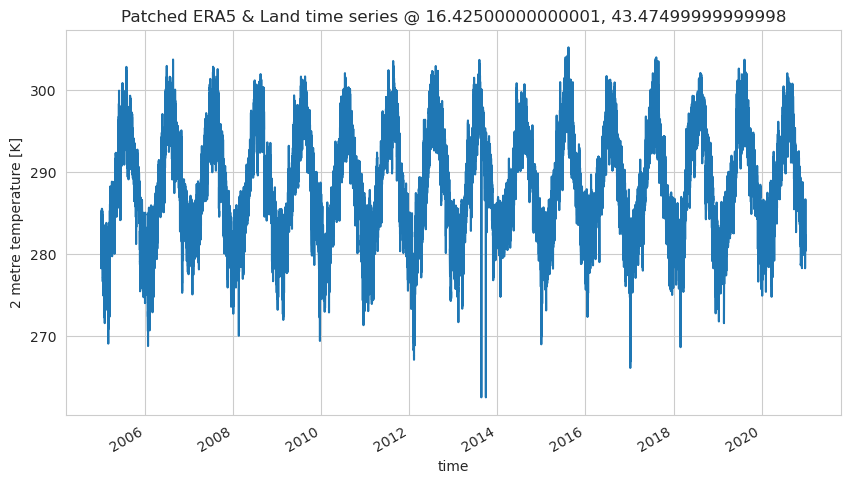

In [46]:
t2m_2013.t2m.plot()
longitude = float(t2m_2013.lon)
latitude = float(t2m_2013.lat)
plt.title(f"Patched ERA5 & Land time series @ {longitude}, {latitude}");
plt.show()

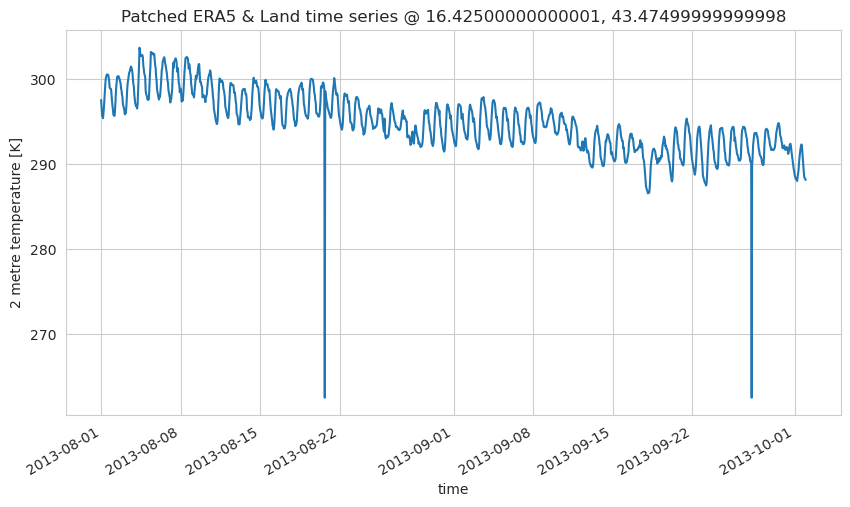

In [47]:
t2m_2013_08_01_to_10_01 = t2m_2013.t2m.sel(time=slice('2013-08-01', '2013-10-01'))
t2m_2013_08_01_to_10_01.plot()
plt.title(f"Patched ERA5 & Land time series @ {longitude}, {latitude}");
plt.show()

## Detect MAD outliers 

The **Median Absolute Deviation** (MAD) is a robust measure of the variability of a univariate sample of quantitative data. It can also refer to the population parameter that is estimated by the MAD calculated from a sample.

> See also: Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.

### Modified Z-score Method

> The Z-score method uses the sample mean and standard deviation. However, these can be affected by a single or multiple extreme values. To avoid such issues, the **modified Z-score** method uses the median and the **Median Absolute Deviation**.

In [48]:
outliers_mad = get_outliers_mad(
    points=t2m_2013.t2m,
    threshold=threshold_mad
)

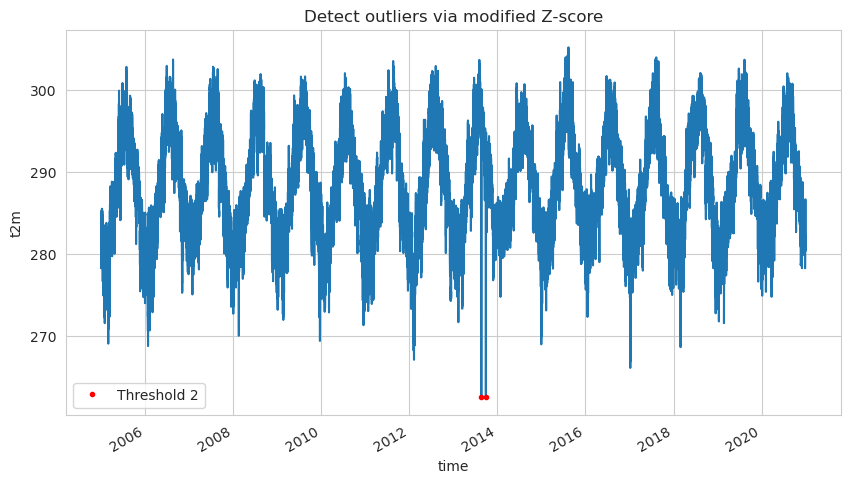

In [49]:
plt.figure(1)
t2m_2013.t2m.plot() + outliers_mad.plot.line('r.', label=f'Threshold {threshold_mad}')
plt.title('Detect outliers via modified Z-score')
plt.legend()
plt.show()

### MAD_e

> The MADₑ method is similar to the SD method but it uses median and **Median Absolute Deviation**, instead of mean and standard deviation.

In [50]:
outliers_mad_e = get_outliers_mad_e(
    points=t2m_2013.t2m,
    threshold=threshold_mad_e
)

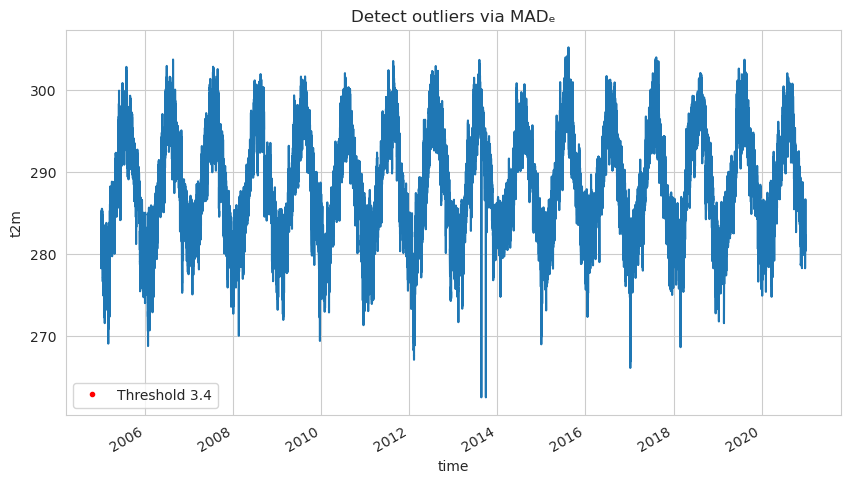

In [51]:
plt.figure(1)
t2m_2013.t2m.plot() + outliers_mad_e.plot.line('r.', label=f'Threshold {threshold_mad_e}')
plt.title('Detect outliers via MADₑ')
plt.legend()
plt.show()

In [52]:
outliers_mad_e_threshold_2 = get_outliers_mad_e(
    points=t2m_2013.t2m,
    threshold=threshold_mad_e_2
)

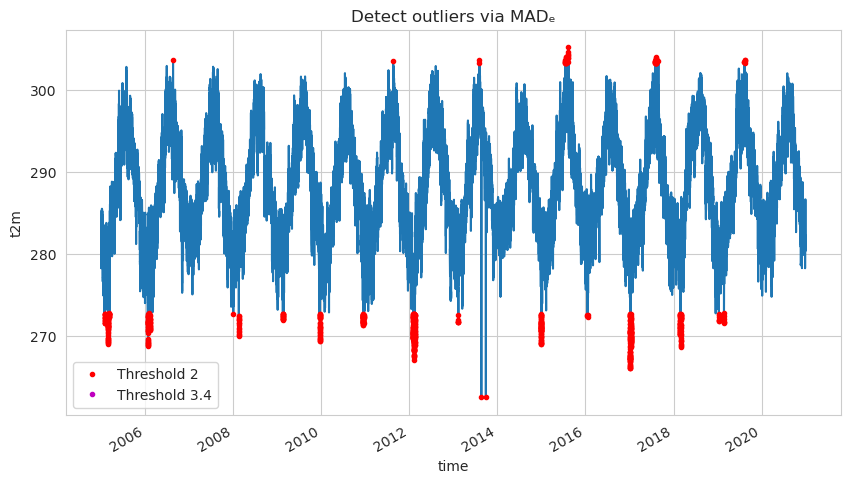

In [53]:
plt.figure(1)
t2m_2013.t2m.plot()
outliers_mad_e_threshold_2.plot.line('r.', label=f'Threshold {threshold_mad_e_2}')
outliers_mad_e.plot.line('m.', label=f'Threshold {threshold_mad_e}')
plt.title('Detect outliers via MADₑ')
plt.legend()
plt.show()

In [54]:
# plt.figure(1)
# t2m_2013.t2m.plot() + outliers_mad_e.plot.line('g', label='Threshold 3.4') + outliers_mad_e_threshold_2.plot.line('r.', label='Threshold 2')
# plt.title('Detect outliers via MADₑ')
# plt.legend()
# plt.show()

In [55]:
## Double MAD

In [56]:
# outliers_double_mad = get_outliers_double_mad(
#     points=np.asarray(t2m_2013.t2m),
# )

## Plot detected outliers

In [ ]:
sns.lineplot(
    x=t2m_2013.time,
    y=t2m_2013.t2m
)
sns.scatterplot(
    x=t2m_2013.time,
    y=outliers_mad.values,
    color='red',
    s=300,
    label=f'MAD {threshold_mad}',
)
sns.scatterplot(
    x=t2m_2013.time,
    y=outliers_mad_e.values,
    color='green',
    s=150,
    label=f'MADₑ {threshold_mad_e}',
)
sns.scatterplot(
    x=t2m_2013.time,
    y=outliers_mad_e_threshold_2.values,
    color='magenta',
    s=80,
    label=f'MADₑ {threshold_mad_e_2}',
)
plt.ylabel('Air temperature @ 2m', weight=900)
plt.title(f'Outliers in {t2m_2013.t2m.name}')
plt.show()

The slightly different versions of the MAD based methods respond differently in terms of the given threshold.